# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2016 (c) Császár Márk, Tóth Bálint Pál (toth.b kukac tmit pont bme pont hu)
</PRE>

# XOR probléma

Az előzőleg (02_01_XOR) bemutatott XOR problémát e notebookban egy Python alapokra építkező, gépi tanulást elősegítő keretrendszerrel, a Kerassal fogjuk megoldani. A Keras az egyik legelterjedtebb mély tanuló keretrendszer, köszönhetően magas szintű megvalósításának. Backend-nek TensorFlow-t és Thenao-t is tud használni.
A kódunk elején betöltjük a Keras csomagból a szükséges modulokat.

In [1]:
# Először is, az egymáshoz képest lineárisan elhelyezkedő neurális hálózat modelljét.
from keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from keras.layers.core import Dense, Activation
# A Callback függvény rengeteg hasznos információt szolgáltat a tanítási folyamat során, amelyekre kíváncsiak
# szoktunk lenni. 
from keras.callbacks import Callback
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


Az előbb már említett Callback függvényre alapozva a TrainingHistory osztállyal tudunk kinyerni értékes metrikákat, amelyek a hálózat tanulási folyamatát jellemzik. 

In [2]:
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon. 
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon. 
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 1 == 0:
            self.losses.append(logs.get('loss'))
            self.valid_losses.append(logs.get('val_loss'))
            self.accs.append(logs.get('acc'))
            self.valid_accs.append(logs.get('val_acc'))
            self.epoch += 1
            
history = TrainingHistory()

In [3]:
# Modell felépítése

# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(output_dim=10, input_dim=2))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# Utolsó réteg definiálása, amelynek egy kimenete van.
model.add(Dense(output_dim=1))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(lr=0.1, momentum=0.001, nesterov=True),
              metrics=['accuracy'])

Tanító adatok megadása és megjelenítése:

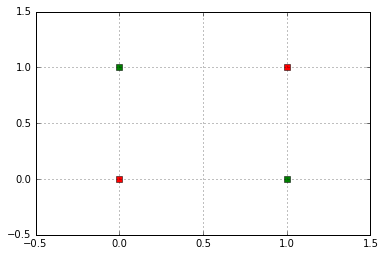

In [4]:
tr_set = np.array([[0,0],[0,1],[1,0],[1,1]], dtype= "float32")
tr_vals = np.array([[0],[1],[1],[0]], dtype= "float32")

# Igaz pontok elhelyezkedése
true_x = [1, 0]
true_y = [0, 1]

# Hamis pontok elhelyezkedése
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid(True)
plt.show()

Validációs adatok (azonos a tanító adatokkal, most azért van rájuk szükség, mert a Keras-nak külön meg kell adni).

In [5]:
val_set = np.array([[0,0],[0,1],[1,0],[1,1]], dtype= "float32")
val_vals = np.array([[0],[1],[1],[0]], dtype= "float32")

# A háló tanítása és tesztelése

Tanítási folyamat és annak a paraméterei. A paraméterek sorát a tanulási adatokkal kell kezdeni. Ez után számos paramétert definiálhatunk, melyek rövid magyarázatát kommentekben olvashatjátok:

In [6]:
model.fit(tr_set,
          # majd a kimenő adatokat.
          tr_vals,
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=4,
          # Tanulási fázisok száma.
          nb_epoch=2500,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Hamis értékre azért volt szükség, hogy a tanulási folyamatot felgyorsítsuk. 
          verbose=0, 
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(val_set, val_vals), 
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[history], 
          # A bemenő adatokat keverje meg a program.
          shuffle= True)

A hálózat hibájának megjelenítése mint a tanító, mind a validációs adathalmazon:

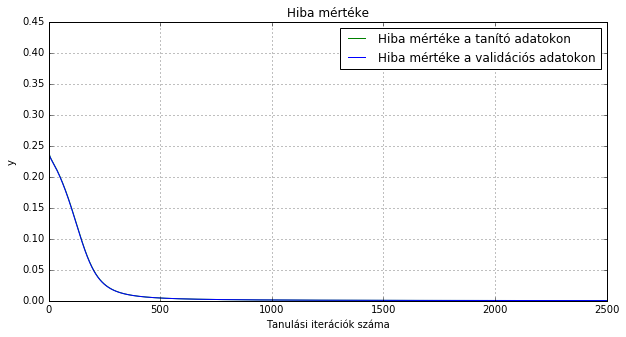

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Tesztelés és megjelenítés fázisa:

0 [ 0.  0.] 0.00  (elvárt eredmény 0)
1 [ 0.  1.] 0.97  (elvárt eredmény 1)
2 [ 1.  0.] 0.97  (elvárt eredmény 1)
3 [ 1.  1.] 0.00  (elvárt eredmény 0)


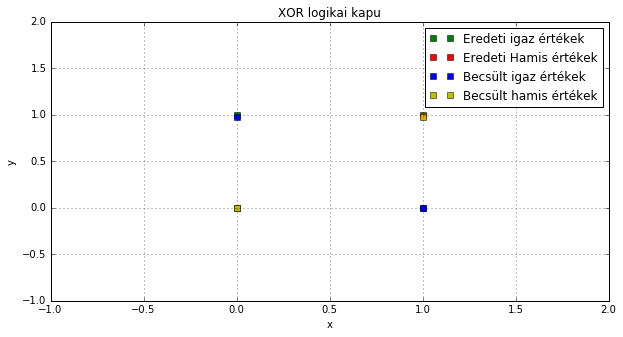

In [8]:
ts_set = np.array([[0,0],[0,1],[1,0],[1,1]], dtype= "float32")
ts_vals = np.array([[0],[1],[1],[0]], dtype= "float32")

# A hálózat becslésének beállításai
pred_res = model.predict(ts_set, batch_size=32, verbose=0)

# Szöveges megjelenítés:

for i in range(len(ts_set)):
    print (i, ts_set[i], '%.2f' % pred_res[i], ' (elvárt eredmény %d)' % ts_vals[i])

# Grafikus megjelenítés
plt.figure(figsize=(10, 5))
plt.title('XOR logikai kapu')

# Eredeti értékek megjelenítése:

# Igaz pontok elhelyezkedése
true_x = [1, 0]
true_y = [0, 1]

# Hamis pontok elhelyezkedése
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs', label = 'Eredeti igaz értékek')
plot2 = plt.plot(false_x, false_y, 'rs', label = 'Eredeti Hamis értékek')


# Háló által becsült értékek megjelenítése:

# Igaz pontok elhelyezkedése
true_x = [1, 0]
true_y = [pred_res[0], pred_res[2]]

# Hamis pontok elhelyezkedése
false_x = [0, 1]
false_y = [pred_res[3], pred_res[1]]

plot3 = plt.plot(true_x, true_y, 'bs', lw = 2, label = 'Becsült igaz értékek')
plot4 = plt.plot(false_x, false_y, 'ys', lw = 2, label = 'Becsült hamis értékek')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid(True)
plt.show()

# Kód röviden
Végül álljon itt a kód lényegi része, letisztázva:

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.optimizers import SGD

X = np.array([[0,0],[0,1],[1,0],[1,1]], "float32")
y = np.array([[0],[1],[1],[0]], "float32")

model = Sequential()
model.add(Dense(output_dim=10, input_dim=2))
model.add(Activation("tanh"))
model.add(Dense(output_dim=1))
model.add(Activation("tanh"))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

history = model.fit(X, y, nb_epoch=2500, batch_size=4, verbose=0)

print(model.predict(X))

[[  4.50015068e-05]
 [  9.92915511e-01]
 [  9.92906451e-01]
 [  1.21891499e-04]]
